In [1]:
from zipfile import ZipFile
f="/content/drive/MyDrive/demo_brain_tumor_seg.zip"
with ZipFile(f,'r') as z:
  z.extractall()
  print('done')

done


In [2]:
import numpy as np 
import os 
import glob 
import cv2, time

train_path='/content/demo_brain_tumor_seg/train/image/'
valid_path='/content/demo_brain_tumor_seg/valid/image/'
test_path='/content/demo_brain_tumor_seg/test/image/'

train_mask_path='/content/demo_brain_tumor_seg/train/masks/'
valid_mask_path='/content/demo_brain_tumor_seg/valid/masks/'
test_mask_path='/content/demo_brain_tumor_seg/test/masks/'


In [3]:

# Arranging the dataset
def data_load(path,mask_path):
    im_list=sorted(glob.glob(path+'*.png'))  # sorted list of the path names
    mask_list=sorted(glob.glob(mask_path+'*.png'))

    SIZE = 128
    image_dataset = []  
    mask_dataset = []  


    for i, image_name in enumerate(im_list):    
        image = cv2.imread(image_name)
        image = cv2.resize(image,(SIZE, SIZE))
        image_dataset.append(image)

    for j, mask_name in enumerate(mask_list):    
        image1 = cv2.imread(mask_name, 0)
        image1 = cv2.resize(image1,(SIZE, SIZE))
        mask_dataset.append(image1)

    #Normalize images
    image_dataset = np.array(image_dataset)/255.
    mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

    return image_dataset, mask_dataset

im_train, gt_train = data_load(train_path,train_mask_path)
im_test, gt_test = data_load(test_path,test_mask_path)
im_valid, gt_valid = data_load(valid_path,valid_mask_path)

#Parameters for model
IMG_HEIGHT = im_train.shape[1]
IMG_WIDTH  = im_train.shape[2]
IMG_CHANNELS = im_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

num_labels = 1  #Binary
batch_size = 2


In [4]:
print('training set shape:{}'.format(im_train.shape))
print('validation set shape:{}'.format(im_valid.shape))
print('testing set shape:{}'.format(im_test.shape))

training set shape:(2364, 128, 128, 3)
validation set shape:(350, 128, 128, 3)
testing set shape:(350, 128, 128, 3)


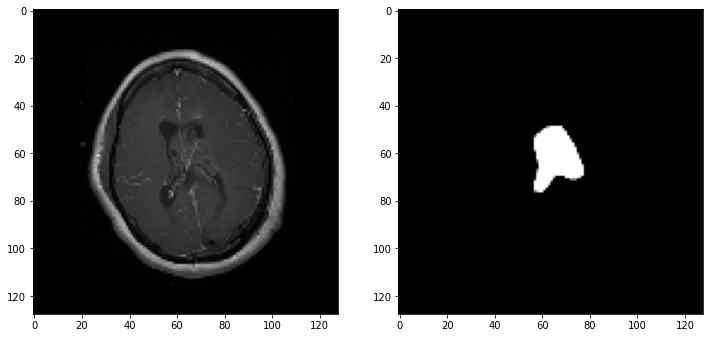

In [5]:
# View the images

import matplotlib.pyplot as plt
import random

image_number = random.randint(0, len(im_train))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(gt_train[image_number][:,:,0], cmap='gray') # this is required because the gt_train is of shape (128, 128, 1) not (128, 128, 3)
plt.show()



In [6]:
# building the model

import tensorflow as tf 


def conv_block(x, filter_size, size):
    
    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)

    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    
    return conv
    
def UNet(input_shape, NUM_CLASSES=1):
    
    inputs = tf.keras.layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1
    conv_128 = conv_block(inputs, 3, 32)
    pool_64 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, 3, 2*32)
    pool_32 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, 3, 4*32)
    pool_16 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, 3, 8*32)
    pool_8 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5
    conv_8 = conv_block(pool_8, 3, 16*32)

    # Upsampling layers
   
    up_16 = tf.keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(conv_8)
    up_16 = tf.keras.layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, 3, 8*32)
    # UpRes 7
    
    up_32 = tf.keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_16)
    up_32 = tf.keras.layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, 3, 4*32)
    # UpRes 8
    
    up_64 = tf.keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_32)
    up_64 = tf.keras.layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, 3, 2*32)
    # UpRes 9
   
    up_128 = tf.keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_64)
    up_128 = tf.keras.layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, 3, 32)

    # 1*1 convolutional layers
   
    conv_final = tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tf.keras.layers.BatchNormalization(axis=3)(conv_final)
    conv_final = tf.keras.layers.Activation('sigmoid')(conv_final)  

    # Model 
    model = tf.keras.models.Model(inputs, conv_final, name="UNet")
    
    return model

model = UNet(input_shape)
model.summary()

# configuring the model for training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [7]:
import time

start1 = time.time() 
unet_history = model.fit(im_train, gt_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(im_valid, gt_valid), 
                    shuffle=False,
                    epochs=15)

stop1 = time.time()

#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

model.save('UNet_15epochs.hdf5')


Epoch 1/15
1182/1182 [==============================] - 41s 23ms/step - loss: 0.4777 - accuracy: 0.9625 - val_loss: 0.7098 - val_accuracy: 0.9101
Epoch 2/15
1182/1182 [==============================] - 26s 22ms/step - loss: 0.2305 - accuracy: 0.9825 - val_loss: 0.3758 - val_accuracy: 0.9018
Epoch 3/15
1182/1182 [==============================] - 26s 22ms/step - loss: 0.1307 - accuracy: 0.9863 - val_loss: 0.2300 - val_accuracy: 0.9334
Epoch 4/15
1182/1182 [==============================] - 26s 22ms/step - loss: 0.0854 - accuracy: 0.9868 - val_loss: 0.2441 - val_accuracy: 0.9221
Epoch 5/15
1182/1182 [==============================] - 26s 22ms/step - loss: 0.0612 - accuracy: 0.9875 - val_loss: 0.1182 - val_accuracy: 0.9572
Epoch 6/15
1182/1182 [==============================] - 26s 22ms/step - loss: 0.0474 - accuracy: 0.9880 - val_loss: 0.1504 - val_accuracy: 0.9414
Epoch 7/15
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0390 - accuracy: 0.9886 - val_loss: 0.0876 -

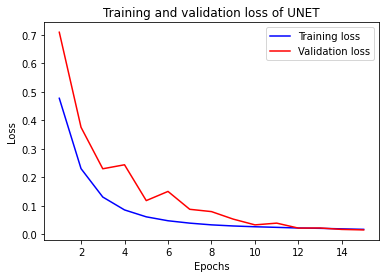

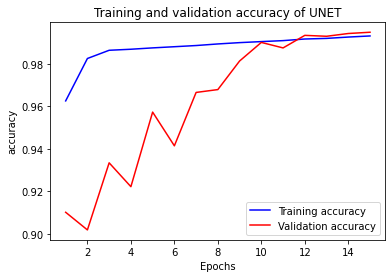

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss1 = unet_history.history['loss']
val_loss1 = unet_history.history['val_loss']
epochs = range(1, len(loss1) + 1)
plt.plot(epochs, loss1, 'b', label='Training loss')
plt.plot(epochs, val_loss1, 'r', label='Validation loss')
plt.title('Training and validation loss of UNET')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = unet_history.history['accuracy']
val_acc = unet_history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy of UNET')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


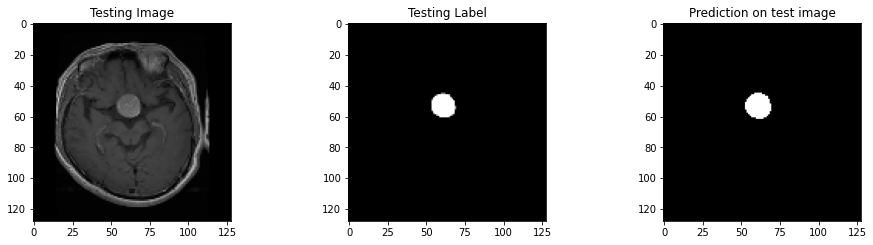

Mean IoU = 0.9143825


In [13]:

from sklearn.metrics import f1_score
from tensorflow.keras.metrics import MeanIoU

test_img_number = random.randint(0, len(im_test))
test_img = im_test[test_img_number]
ground_truth=gt_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy()) 


In [10]:
#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
F1_weighted_avg = 0

for img in range(0, im_test.shape[0]):
    temp_img = im_test[img]
    ground_truth=gt_test[img]
    gt_=ground_truth.squeeze()>0
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    
    f1_weighted = f1_score(gt_.flatten(), prediction.flatten(), average='weighted')
    F1_weighted_avg += f1_weighted


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)
print(f'Average F1 for all frames: {F1_weighted_avg/im_test.shape[0]}')
    

1/1 [==============================] - 0s 18ms/step
Mean IoU is:  [0.71271586]
Average F1 for all frames: 0.9802162578501825


In [11]:
df

,IoU
0,0.970437
1,0.825823
2,0.893010
3,0.901562
4,0.849809
...,...
345,0.926304
346,0.943859
347,0.912261
348,0.761243
